This notebook shows how to use [GEMDAT](https://gemdat.readthedocs.org) to compute information related to molecular orientations and rotations.

First, it computes the bonds between central and satellite atoms, following the user's instructions. Then it computes their trajectory in cartesian, spherical and conventional form. If a symmetry group is defined, the statistics can be enhanced by exploiting the symmetry. Now the user can compute and plot the relevant information.

As input you will need:

1. [trajectory](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.analyzer.SpacegroupAnalyzer)
2. Orientational indication including:
    - central atom species
    - satellite atom species
    - number of expected neighbors
3. Optionally, a list of transformations that you want to apply to the unit vector trajectory. The user can combine the following operations:
    - `normalize`: the trajectory of unit vectors is scaled to $[0,1]$
    - `conventional`: convert the trajectory to conventional coordinates. A conventional unit cell only contains one lattice point, while the primitive cell contains the Bravais lattice. This means that the conventional form is simpler to visualize and compare
    - `symmetrize`: applies symmetry operations specified via 4.
4. Optionally, the symmetry group, either as:
    - [Hermann–Mauguin notation](https://en.wikipedia.org/wiki/Hermann%E2%80%93Mauguin_notation)
    - explicit symmetry operations as 3x3 matrices


The resulting orientation information can be visualized on a rectilinear plot, while the user can also access the statistics of the bond length. Finally, it is possible to plot the autocorrelation obtaining information about expected time for rotations. 

In [1]:
from __future__ import annotations

import random
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import time

from gemdat import Trajectory, plots, Orientations
from gemdat.utils import VASPCACHE_ROTATIONS, cartesian_to_spherical

/home/stef/python/gemdat/.venv/lib64/python3.12/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
# Fix the seed for reproducibility
random.seed(42)
np.random.seed(42)

Load the trajectory

In [3]:
# To use your own data:
#trajectory = Trajectory.from_vasprun('path/to/your/vasprun.xml')
trajectory = Trajectory.from_cache(VASPCACHE_ROTATIONS)

In [4]:
# Extract the trajectories of the unit vectors
central_atoms = 'S'
satellite_atoms = 'O'
n_expected_neigh = 8
rotational_traj = Orientations(trajectory, central_atoms, satellite_atoms, n_expected_neigh)

In [5]:
# You can easily access the unit vectors in direct coordinates
direct_cart = rotational_traj.vectors

It is also possible to apply a list of transformation operations to transform the unit vector trajectory.
For example you can get the normalized conventional coordinates like this 

In [6]:
prim_to_conv_matrix = np.array(
    [[1 / 2**0.5, -1 / 6**0.5, 1 / 3**0.5],
     [1 / 2**0.5, 1 / 6**0.5, -1 / 3**0.5], 
     [0, 2 / 6**0.5, 1 / 3**0.5],
])

norm_conv = rotational_traj.normalize().conventional(prim_to_conv_matrix)

It is also possible to set different primitive cells via `Orientations.prim_to_conv_matrix`:

In [7]:
eye = np.eye(3)

# and then you can apply them
conv = rotational_traj.conventional(prim_to_conv_matrix=eye)

It is also possible to use **symmetry** transformations, which are very useful to improve the statistics of the trajectory. In order to do so, you first have to specify the symmetry of your problem

In [8]:
sym_ops = np.asarray([[ [ 0, 1, 0], [1, 0, 0] , [1, 0, 0]]])

then you can get the trajectory symmetric under these operations

In [9]:
traj_manual_sym =  rotational_traj.symmetrize(sym_ops=sym_ops)

However, GEMDAT also provides a way to use symmetry group via [pymatgen](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.analyzer.PointGroupOperations), following the Hemann-Mauguin notation. For example here we select the Oh point group which is denoted as `m-3m`

In [10]:
traj_sym =  rotational_traj.symmetrize(sym_group='m-3m')

It is also possible to convert any trajectory in spherical coordinates

In [11]:
direction_spherical = cartesian_to_spherical(direct_cart=traj_manual_sym.vectors, degrees=True)

/home/stef/python/gemdat/src/gemdat/utils.py:227: RuntimeWarning: invalid value encountered in divide
  el = np.arcsin(z / r)


## Plots
We compute the **rectilinear plot** which is a 2d map of the azimutal and elevation angles.
By *default*, it uses the `transformed_trajectory`, so remember to specify which transformation you want to use.

Here we show the effect of different transformations their ordering

/tmp/ipykernel_93937/3293266295.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_93937/3293266295.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_93937/3293266295.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_93937/3293266295.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_93937/3293266295.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_93937/3293266295.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


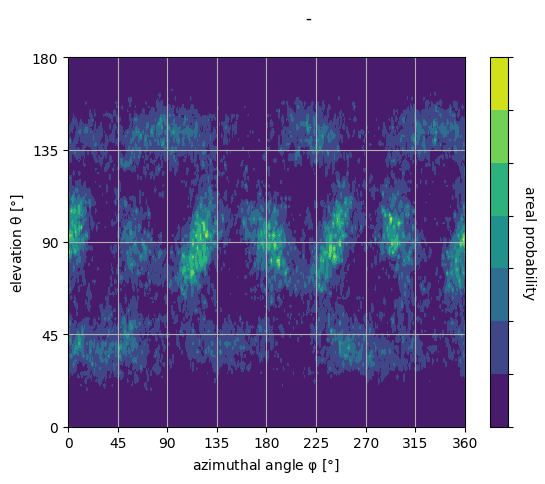

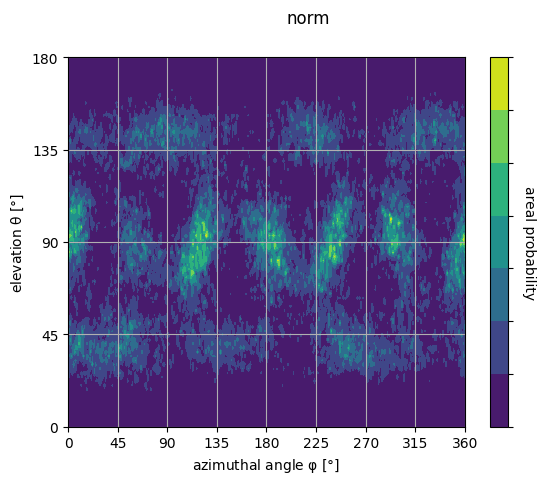

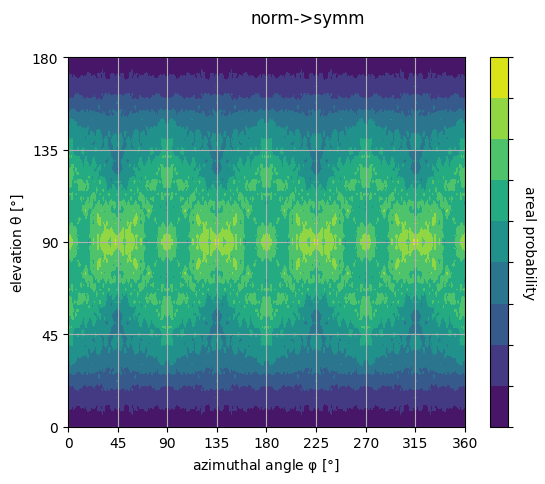

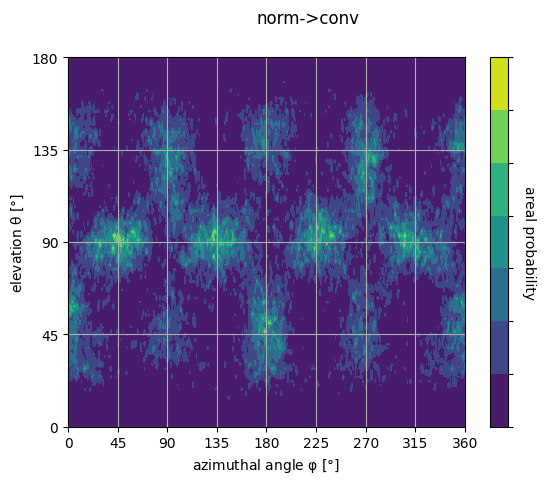

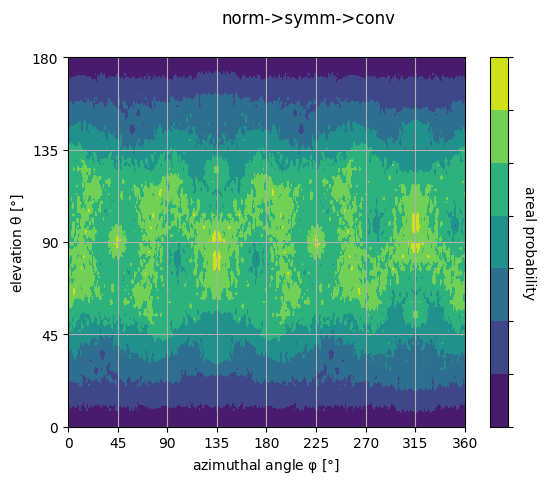

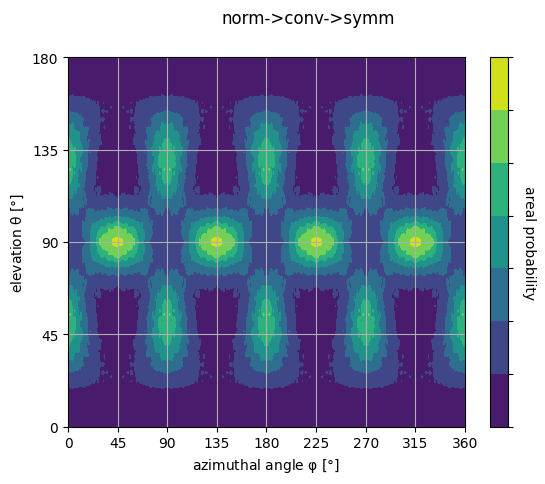

In [12]:
fig = plots.rectilinear_plot(orientations=rotational_traj, normalize_histo=False)
fig.suptitle('-')
fig.show()

traj = rotational_traj.normalize()
fig = plots.rectilinear_plot(orientations=traj, normalize_histo=False)
fig.suptitle('norm')
fig.show()

traj = rotational_traj.normalize().symmetrize(sym_group='m-3m')
fig = plots.rectilinear_plot(orientations=traj, normalize_histo=False)
fig.suptitle('norm->symm')
fig.show()

traj = rotational_traj.normalize().conventional(prim_to_conv_matrix)
fig = plots.rectilinear_plot(orientations=traj, normalize_histo=False)
fig.suptitle('norm->conv')
fig.show()

traj = rotational_traj.normalize().symmetrize(sym_group='m-3m').conventional(prim_to_conv_matrix)
fig = plots.rectilinear_plot(orientations=traj, normalize_histo=False)
fig.suptitle('norm->symm->conv')
fig.show()

traj = rotational_traj.normalize().conventional(prim_to_conv_matrix).symmetrize(sym_group='m-3m')
fig = plots.rectilinear_plot(orientations=traj, normalize_histo=False)
fig.suptitle('norm->conv->symm')
fig.show()


Plot the bond length distribution. A skewed gaussian is automatically fitted to the data in order to provide useful information.

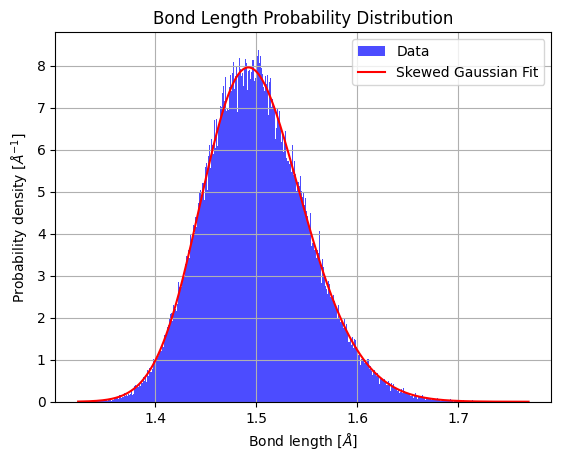

In [13]:
fig1 = plots.bond_length_distribution(orientations=rotational_traj, bins=1000)

Now we compute and plot the autocorrelation of the unit vectors:

/tmp/ipykernel_93937/2065601658.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


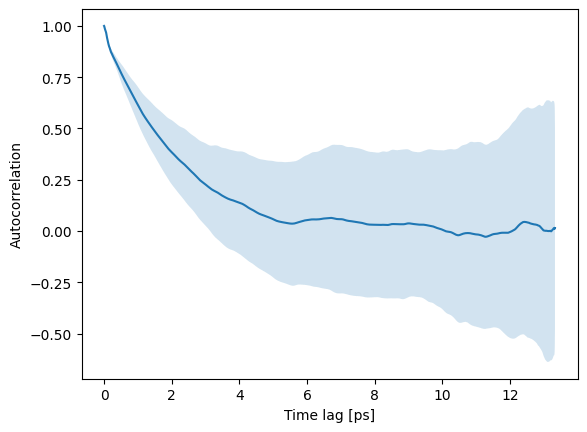

In [14]:
fig1 = plots.unit_vector_autocorrelation(orientations=rotational_traj)
fig1.show()

In [15]:
# Notice that the user can also calculate the autocorrelation function as follows
traj = rotational_traj.normalize().conventional(prim_to_conv_matrix).symmetrize(sym_group='m-3m')

from gemdat.rotations import mean_squared_angular_displacement
autocorrelation = mean_squared_angular_displacement(traj.vectors)

In this notebook, we want to compare the autocorrelation implemented in `GEMDAT` using FFT, with a direct implementation that was developed for a previous matlab code. For more details look [here](https://github.com/GEMDAT-repos/gemdat-notebooks/blob/main/msd.ipynb) 

For this comparison we define in the next block the matlab functions that we want to compare:

In [16]:
def simple_autocorr(direct_cart, Npt=100):
    start_time = time.time()
    Nts = len(direct_cart)  # number timesteps
    ep = Nts - 1
    dts = np.round(np.logspace(1, np.log10(ep), Npt)).astype(int)
    mean_autocorr = np.zeros(len(dts))
    for k, dt in enumerate(dts):
        autocorr = np.sum(direct_cart[:-dt] *
                          direct_cart[dt:],
                          axis=-1)
        mean_autocorr[k] = np.mean(autocorr)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return dts * 0.002, mean_autocorr  #time in ps

from concurrent.futures import ThreadPoolExecutor
def autocorr_par(direct_cart, Npt=100):
    def compute_autocorr(dt):
        autocorr = np.sum(direct_cart[:-dt] * direct_cart[dt:], axis=-1)
        mean_autocorr = np.mean(autocorr)
        std_autocorr = np.std(autocorr)
        return mean_autocorr, std_autocorr
    Nts = len(direct_cart)
    ep = Nts - 1
    dts = np.round(np.logspace(1, np.log10(ep), Npt)).astype(int)
    mean_autocorr = np.zeros(len(dts))
    std_autocorr = np.zeros(len(dts))
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(compute_autocorr, dts))
    for i, (mean, std) in enumerate(results):
        mean_autocorr[i] = mean
        std_autocorr[i] = std
    return dts * 0.002, mean_autocorr, std_autocorr

And we compare `gemdat.unit_vector_autocorrelation` with the matlab implementation

/tmp/ipykernel_93937/3361556222.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


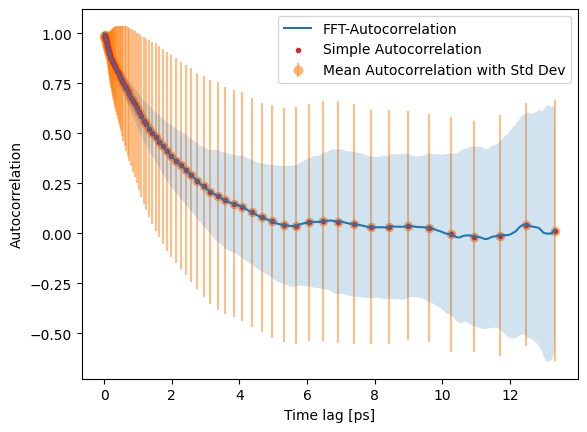

In [17]:
fig1 = plots.unit_vector_autocorrelation(orientations=traj)
ax1 = plt.gca()
x, y = simple_autocorr(traj.vectors)
ax1.scatter(x, y, marker='.', color='tab:red', label='Simple Autocorrelation')
x, y, y_std = autocorr_par(traj.vectors)
ax1.errorbar(x,
             y,
             zorder=-1,
             yerr=y_std,
             fmt='o',
             alpha=0.5,
             label='Mean Autocorrelation with Std Dev')
ax1.legend()
fig1.show()